
目前为止，我们已经看到了如何定义网络，计算损失，并更新网络的权重。所以你现在可能会想,

数据应该怎么办呢？
通常来说，当必须处理图像、文本、音频或视频数据时，可以使用python标准库将数据加载到numpy数组里。然后将这个数组转化成`torch.*Tensor`。

对于图片，有 `Pillow`，`OpenCV` 等包可以使用
对于音频，有 `scipy` 和 `librosa` 等包可以使用
对于文本，不管是原生 python 的或者是基于 Cython 的文本，可以使用 `NLTK` 和 `SpaCy`
特别对于视觉方面，我们创建了一个包，名字叫`torchvision`，其中包含了针对`Imagenet`、`CIFAR10`、`MNIST` 等常用数据集的数据加载器 (`data loaders`），还有对图像数据转换的操作，即`torchvision.datasets`和`torch.utils.data.DataLoader`。

这提供了极大的便利，可以避免编写样板代码。

在这个教程中，我们将使用CIFAR10数据集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。在CIFAR-10里面的图片数据大小是3x32x32，即：三通道彩色图像，图像大小是32x32像素。

# 训练一个图片分类器

我们将按顺序做以下步骤：

1. 通过`torchvision`加载`CIFAR10`里面的训练和测试数据集，并对数据进行标准化
2. 定义卷积神经网络
3. 定义损失函数
4. 利用训练数据训练网络
5. 利用测试数据测试网络

## 1.加载并标准化CIFAR10
使用`torchvision`加载 `CIFAR10` 超级简单。

`torchvision` 数据集加载完后的输出是范围在 \[0, 1\] 之间的 `PILImage`。我们将其标准化为范围在 \[-1, 1\] 之间的张量。

In [41]:
import torch 
import torchvision
import torchvision.transforms as transforms

import os

#print('current path :', os.getcwd())

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))])
trainset = torchvision.datasets.CIFAR10(root='.data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='.data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')  # predfined classes

Files already downloaded and verified


乐趣所致，现在让我们可视化部分训练数据。

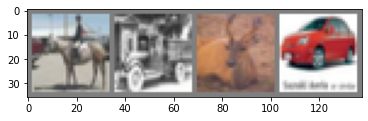

horse truck  deer   car


In [42]:
import matplotlib.pyplot as plt
import numpy as np

# 输出图像的函数
def imgshow(img):
    img = img/2+0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

# 随机获取训练图片
dataIter = iter(trainloader)
images, labels = dataIter.next()

# 显示图片
imgshow(torchvision.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s'%classes[labels[j]] for j in range(4)))

# 2.定义一个卷积神经网络
将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像(替代原来定义的单通道图像）。

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,6,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6,16,5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

# 3.定义损失函数和优化器
我们使用多分类的交叉熵损失函数和随机梯度下降优化器(使用 momentum ）。

In [44]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 4.训练网络
事情开始变得有趣了。我们只需要遍历我们的数据迭代器，并将输入“喂”给网络和优化函数。

In [45]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # get inputs

        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i%2000==1999:
            print('[%d, %5d] loss %.3f'%(epoch+1, i+1, running_loss/2000))
            running_loss=0.0

print('train finished')

model_path = './cifar_net.pth'
torch.save(net.state_dict(), model_path) # 保存已训练得到的模型

[1,  2000] loss 2.218
[1,  4000] loss 1.883
[1,  6000] loss 1.699
[1,  8000] loss 1.592
[1, 10000] loss 1.523
[1, 12000] loss 1.471
[2,  2000] loss 1.378
[2,  4000] loss 1.363
[2,  6000] loss 1.329
[2,  8000] loss 1.327
[2, 10000] loss 1.285
[2, 12000] loss 1.259
train finished


看这里熟悉更多PyTorch [保存模型](https://pytorch.org/docs/stable/notes/serialization.html)的细节
# 5.使用测试数据测试网络
我们已经在训练集上训练了2遍网络。但是我们需要检查网络是否学到了一些东西。

我们将通过预测神经网络输出的标签来检查这个问题，并和正确样本进行 ( `ground-truth`）对比。如果预测是正确的，我们将样本添加到正确预测的列表中。

ok，第一步。让我们展示测试集中的图像来熟悉一下。

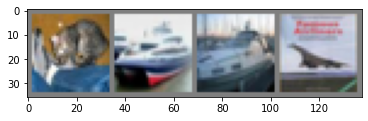

GroundTruth:    cat  ship  ship plane


In [46]:
dataIter = iter(testloader)
images, labels = dataIter.next()

# 输出图片
imgshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s'%classes[labels[j]] for j in range(4)))

下一步，让我们加载保存的模型（注意：在这里保存和加载模型不是必要的，我们只是为了解释如何去做这件事）

In [47]:
net = Net()
net.load_state_dict(torch.load(model_path))  # 加载模型

outputs = net(images)                       # 输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。
_, predicted = torch.max(outputs, 1)        # 最高量值的下标/索引

print('Predicted : ', ' '.join('%5s'%classes[labels[j]] for j in range(4)))

Predicted :    cat  ship  ship plane


结果还不错。

让我们看看网络在整个数据集上表现的怎么样。

In [52]:
correct = 0 
total = 0

ifOutput=False

with torch.no_grad():   # 此作用域内，不计算梯度
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        if not ifOutput:
            print(labels.size())
            print(predicted.size())
            ifOutput = True
        correct += (predicted ==labels).sum().item()

print('Accuracy of network on 10000 test images : %d %%' % (100.0*correct/total))

torch.Size([4])
torch.Size([4])
Accuracy of network on 10000 test images : 56 %


这比随机选取(即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

# 查看每个类别的正确率

In [32]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label]+=1

for i in range(10):
    print('Accuracy of %5s : %2d %%'%(classes[i], 100.0*class_correct[i]/class_total[i]))
    

Accuracy of plane : 56 %
Accuracy of   car : 76 %
Accuracy of  bird : 42 %
Accuracy of   cat : 40 %
Accuracy of  deer : 43 %
Accuracy of   dog : 51 %
Accuracy of  frog : 66 %
Accuracy of horse : 64 %
Accuracy of  ship : 66 %
Accuracy of truck : 52 %


# 在GPU上训练
与将一个张量传递给 GPU 一样，可以这样将神经网络转移到 GPU 上。

如果我们有 cuda 可用的话，让我们首先定义第一个设备为可见 cuda 设备：

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

net_gpu = Net()
net_gpu.to(device)          # 递归遍历所有模块，并将它们的参数和缓冲区转换为CUDA张量

#inputs = inputs.to(device)      # 将输入和目标在每一步都送入GPU
#labels = labels.to(device)      # 将输入和目标在每一步都送入GPU

correct = 0 
total = 0

criterion_gpu = nn.CrossEntropyLoss()
optimizer_gpu = optim.SGD(net_gpu.parameters(), lr=0.001, momentum=0.9)

for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data # get inputs

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer_gpu.zero_grad()

        # forward + backward + optimize
        outputs = net_gpu(inputs)
        loss = criterion_gpu(outputs, labels)
        loss.backward()
        optimizer_gpu.step()

        # print statistics
        running_loss += loss.item()
        if i%2000==1999:
            print('[%d, %5d] loss %.3f'%(epoch+1, i+1, running_loss/2000))
            running_loss=0.0

with torch.no_grad():   # 此作用域内，不计算梯度
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = net_gpu(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        #print('predicted size : ', predicted.size())
        #print('labels size    : ', labels.size())
        correct += (predicted ==labels).sum().item()

print('Accuracy of network on 10000 test images : %d %%' % (100.0*correct/total))


cuda:0
[1,  2000] loss 2.220
[1,  4000] loss 1.856
[1,  6000] loss 1.662
[1,  8000] loss 1.559
[1, 10000] loss 1.504
[1, 12000] loss 1.473
[2,  2000] loss 1.376
[2,  4000] loss 1.370
[2,  6000] loss 1.353
[2,  8000] loss 1.303
[2, 10000] loss 1.268
[2, 12000] loss 1.291
Accuracy of network on 10000 test images : 56 %


为什么我们感受不到与CPU相比的巨大加速？因为我们的网络实在是太小了。

尝试一下：加宽你的网络(注意第一个`nn.Conv2d`的第二个参数和第二个`nn.Conv2d`的第一个参数要相同），看看能获得多少加速。

已实现的目标：

在更高层次上理解 PyTorch 的 Tensor 库和神经网络
训练一个小的神经网络做图片分类
在多GPU上训练
如果希望使用您所有GPU获得更大的加速，请查看[Optional: Data Parallelism](https://pytorch.org/tutorials/beginner/blitz/data_parallel_tutorial.html)。

接下来要做什么？

[Train neural nets to play video games](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html    )

[Train a state-of-the-art ResNet network on imagenet](https://github.com/pytorch/examples/tree/master/imagenet)

[Train a face generator using Generative Adversarial Networks](https://github.com/pytorch/examples/tree/master/dcgan)

[Train a word-level language model using Recurrent LSTM networks](https://github.com/pytorch/examples/tree/master/word_language_model)

[More examples](https://github.com/pytorch/examples)

[More tutorials](https://github.com/pytorch/tutorials)

[Discuss PyTorch on the Forums](https://discuss.pytorch.org/)

[Chat with other users on Slack](https://pytorch.slack.com/messages/beginner/)